In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
os.chdir(root_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.6)
sns.set_style('whitegrid')

from scipy.signal import savgol_filter

# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}


def gravy(seq):
    if len(seq) == 0:
        return 0
    else:
        return np.mean([kd[i] for i in seq])

def hydrop(seq):
    return [kd[i] for i in seq]

def filt(seq, w=15, p=2):
    aa = hydrop(seq)
    return savgol_filter(aa, w, p)

# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
flexibilities_vih = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
"G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
"K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
"Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
"T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}

def flex(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return savgol_filter([flexibilities_vih[i] for i in seq], 15, 2)


In [3]:
df = pd.read_pickle('Signal_Manuscript/results/signalp5_train_all.pkl.gz')
df['Filtered_Hydrop'] = df['Protein'].str[:40].apply(filt)
df['Category'] = df['Label'].apply(lambda x: ['SP']*40 if x==1 else ['NO_SP']*40)

In [4]:
new_df = pd.DataFrame()
new_df['Positions'] = list(range(1, 41))*df.shape[0]
new_df['Positions'] = new_df['Positions'].astype(float)

new_df['Filtered_Hydrop'] = df['Filtered_Hydrop'].explode().values.astype(float)

new_df['Type'] = df['Category'].explode().values
new_df.head(2)

,Positions,Filtered_Hydrop,Type
0,1.0,0.003824,SP
1,2.0,0.467899,SP


In [5]:
df['Temp'] = df['Protein'] + '#' + df['Cleavage'].astype(str)
def f(x):
    '''
    This will give the filterd hydrophobicity 
    at cleavage site position
    
    '''
    seq, cs = x.split('#')
    try:
        cs = int(float(cs))
        return filt(seq)[cs]
    except Exception:
        pass

In [6]:
df['CS'] = df['Temp'].apply(f)

sp_df = df[~df['CS'].isna()].copy()

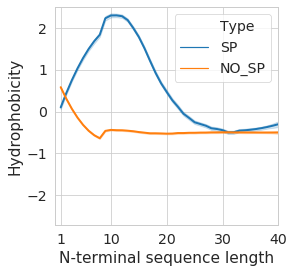

In [63]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)
fig = plt.figure(figsize=(4, 4))
# ax = sns.kdeplot(sp_df['Cleavage'], sp_df['CS'],shade=True, \
#                  shade_lowest=False, n_levels=10, cbar=False,\
#                 cmap='Blues', alpha=0.5)


ax = sns.lineplot(x="Positions", y="Filtered_Hydrop", data=new_df, hue="Type", lw=2)
ax.set_xticks([1, 10, 20, 30, 40]);
ax.set_ylabel('Hydrophobicity')
ax.set_xlabel('N-terminal sequence length')
ax.set_ylim(-2.7, 2.5)
ax.set_xlim(0, 40);
plt.savefig('/Volumes/userdata/student_users/bikashkumarbhandari/Documents/Thesis/Committee_Meeting_April_2020/Jupyter_Notebook/figs/SP_NOSP_LinePlot.pdf',\
            bbox_inches='tight', pad_inches=0);

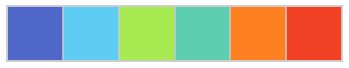

In [20]:
Slipstream6 = ['#4e67c8', '#5eccf3', '#a7ea52', '#5dceaf', '#ff8021', '#f14124']
sns.palplot(Slipstream6)

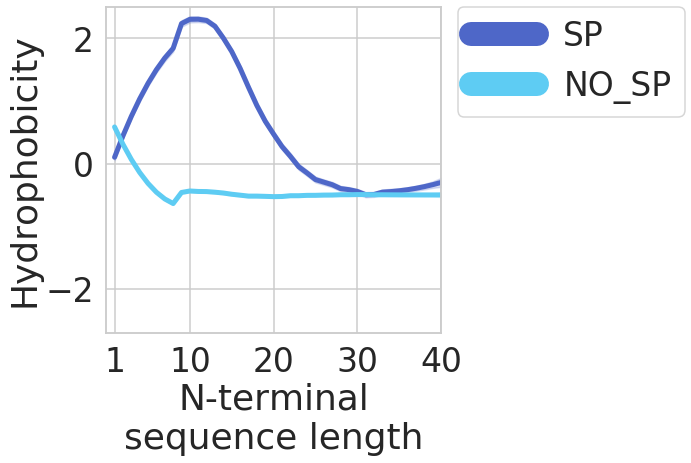

In [27]:


sns.set_style("whitegrid")

plt.figure(figsize=(6, 6))
sns.set_context("talk", font_scale=2)

lw = 3

# ax = sns.kdeplot(sp_df['Cleavage'], sp_df['CS'],shade=True, \
#                  shade_lowest=False, n_levels=10, cbar=False,\
#                 cmap='Blues', alpha=0.5)

ax = sns.lineplot(x="Positions", y="Filtered_Hydrop", data=new_df, hue="Type", lw=5, palette=Slipstream6[:2])
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(8*lw)
ax.set_xticks([1, 10, 20, 30, 40]);
ax.set_ylabel('Hydrophobicity')
ax.set_xlabel('N-terminal\nsequence length')
ax.set_ylim(-2.7, 2.5)
ax.set_xlim(0, 40);